In [1]:
#Isolation Forest Anomaly Detection

import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Pre Processing
#df = pd.DataFrame()
#desired = 200000
#chunksize = 5000

# Reading the file in chunks
#for chunk in pd.read_csv('utd19_u.csv', chunksize=chunksize, low_memory=False):
#    chunk_bolton = chunk[chunk['city'] == "bolton"]
#    chunk_non_nan = chunk_bolton.dropna(subset=['speed', 'flow', 'occ', 'detid'])
#    df = pd.concat([df, chunk_non_nan], ignore_index=True)
#    if df.shape[0] >= desired:
#        print(f"Desired number of rows reached: {df.shape[0]}")
#        break

# Trim excess
#if df.shape[0] > desired:
#    df = df.head(desired)

# Final DataFrame size
#print(f"Final DataFrame size: {df.shape}")

# Save
#df.to_csv('filtered_data.csv', index=False)

df = pd.read_csv('filtered_data.csv')
#df = df[['speed', 'flow', 'occ']]
df.head(10)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   day       200000 non-null  object 
 1   interval  200000 non-null  int64  
 2   detid     200000 non-null  object 
 3   flow      200000 non-null  float64
 4   occ       200000 non-null  float64
 5   error     158545 non-null  float64
 6   city      200000 non-null  object 
 7   speed     200000 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 12.2+ MB


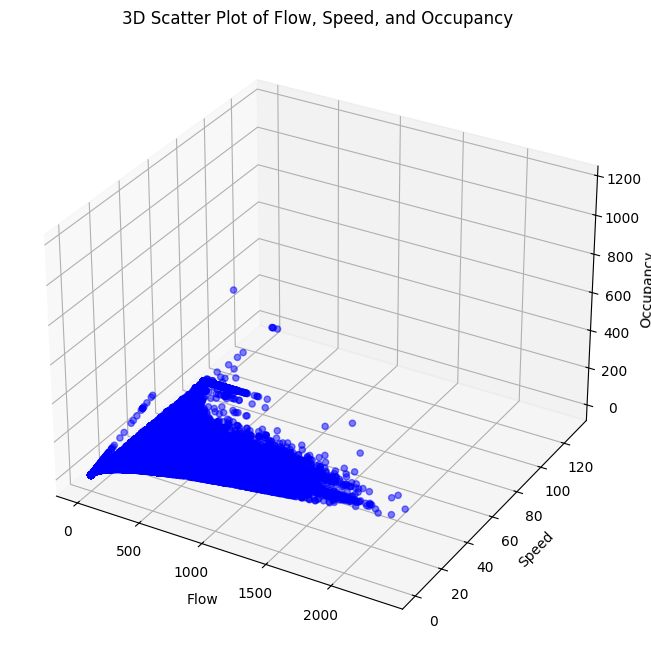

In [2]:
# Plotting

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df['flow'], df['speed'], df['occ'], c='blue', marker='o', alpha=0.5)

ax.set_xlabel('Flow')
ax.set_ylabel('Speed')
ax.set_zlabel('Occupancy')
plt.title('3D Scatter Plot of Flow, Speed, and Occupancy')

plt.show()

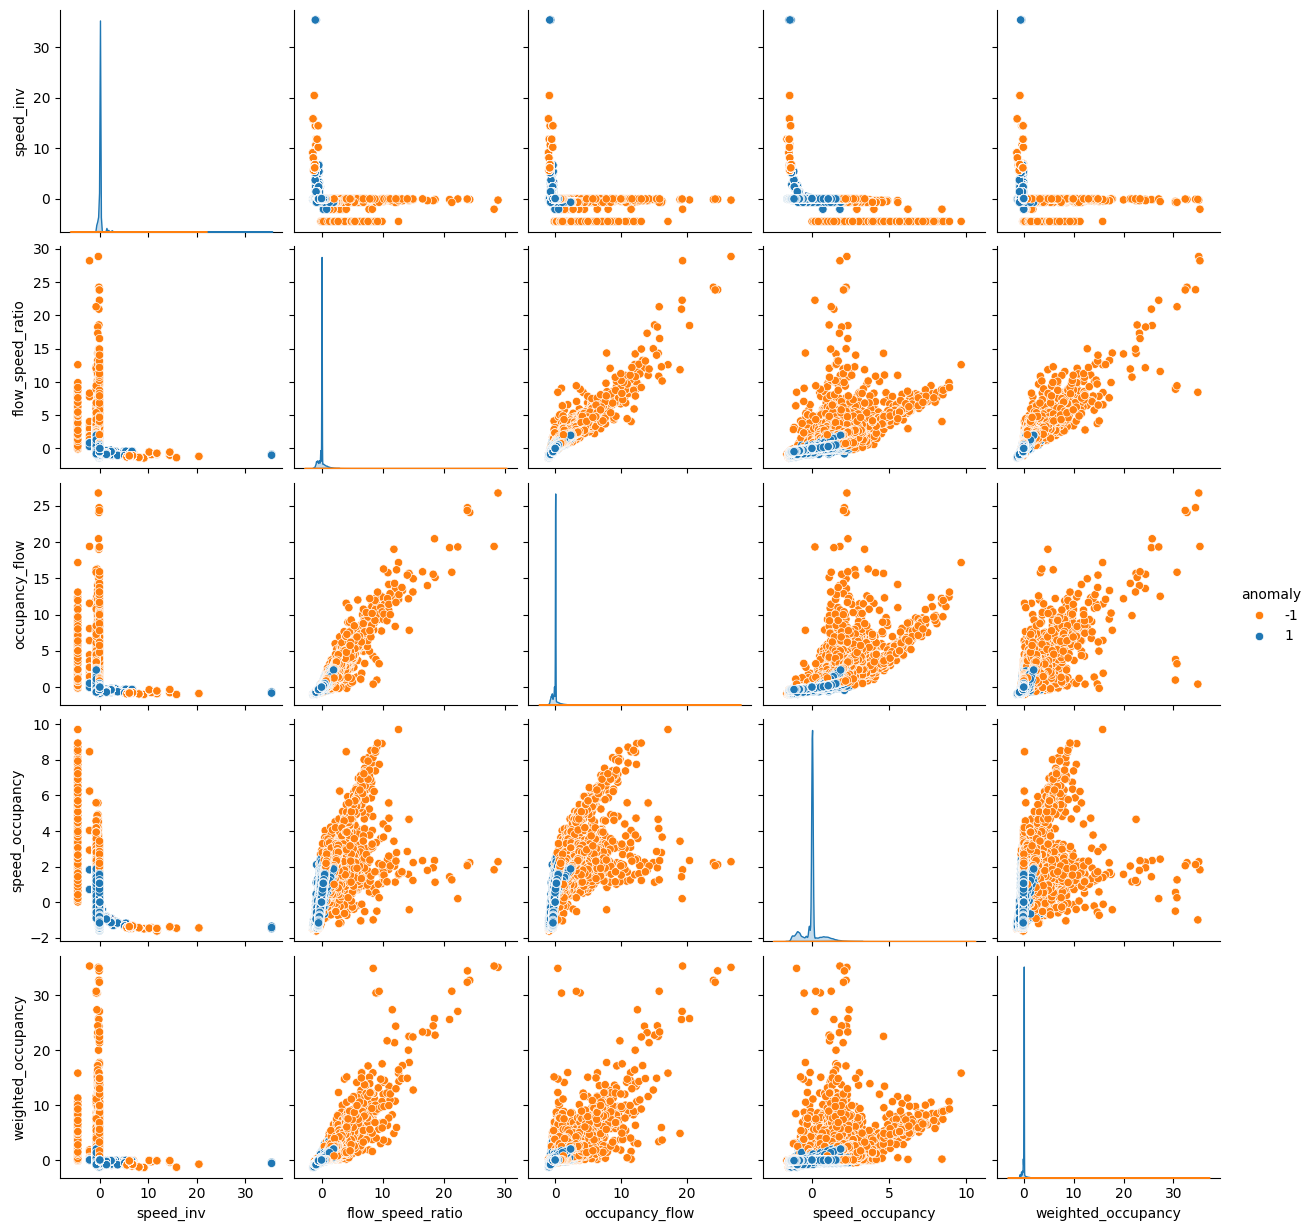

In [3]:
# Isolation Forest

from sklearn.model_selection import KFold
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import numpy as np
import seaborn as sns

det_ids = df['detid'].unique()
combined_results = pd.DataFrame()
sensor_models = {}

for det_id in det_ids:
    sensor_data = df[df['detid'] == det_id].copy()
    
    # Zero Speeds
    sensor_data.loc[sensor_data['speed'] == 0, 'speed'] = np.finfo(float).eps

    # Feature Engineering
    sensor_data['speed_inv'] = 1 / sensor_data['speed']
    sensor_data['flow_speed_ratio'] = sensor_data['flow'] / sensor_data['speed']
    sensor_data['occupancy_flow'] = sensor_data['occ'] * sensor_data['flow']
    sensor_data['speed_occupancy'] = sensor_data['speed'] * sensor_data['occ']
    sensor_data['weighted_occupancy'] = sensor_data['occ'] * sensor_data['speed_inv']
    
    # Scale features
    features_to_scale = ['speed_inv', 'flow_speed_ratio', 'occupancy_flow', 'speed_occupancy', 'weighted_occupancy']
    scaler = StandardScaler()
    sensor_data[features_to_scale] = scaler.fit_transform(sensor_data[features_to_scale])
    
    # Train model
    clf = IsolationForest(contamination=0.05, random_state=42)
    clf.fit(sensor_data[features_to_scale])

    sensor_models[det_id] = clf

    # Anomaly score and label
    sensor_data['anomaly_score'] = clf.decision_function(sensor_data[features_to_scale])
    sensor_data['anomaly'] = clf.predict(sensor_data[features_to_scale])

    # Combine results into one dataframe
    combined_results = pd.concat([combined_results, sensor_data], ignore_index=True)

# Display combined results
palette = ['#ff7f0e', '#1f77b4']
sns.pairplot(combined_results, vars=['speed_inv', 'flow_speed_ratio', 'occupancy_flow', 'speed_occupancy', 'weighted_occupancy'], hue='anomaly', palette=palette)

plt.show()

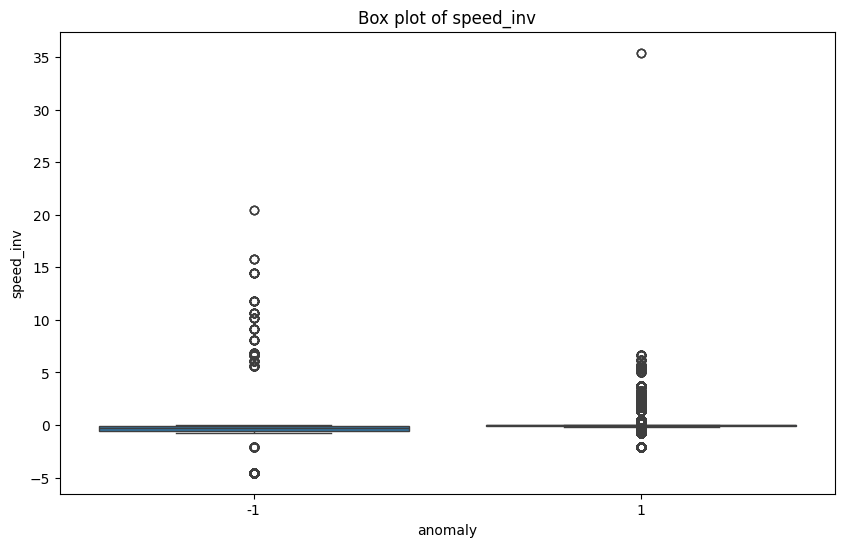

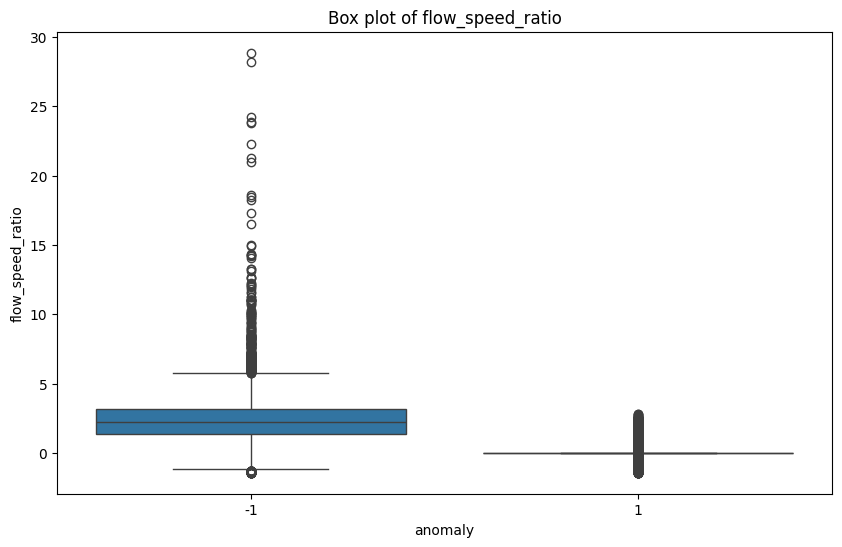

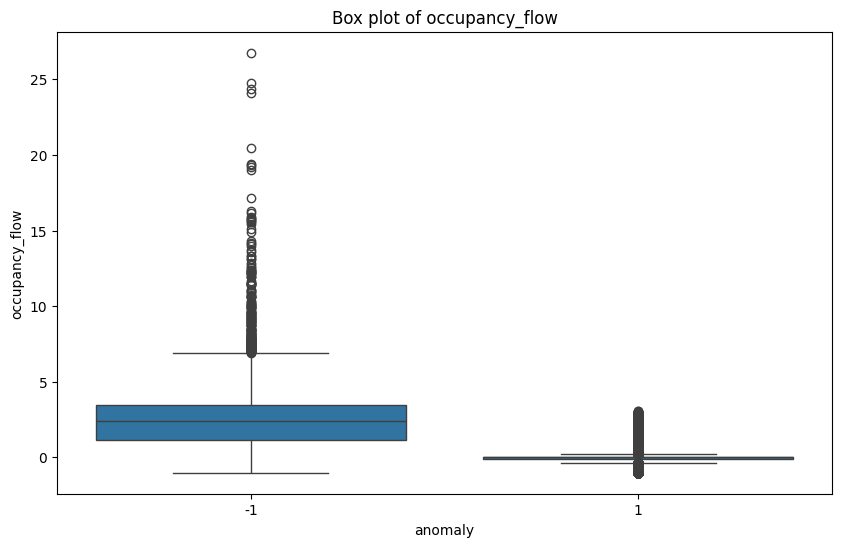

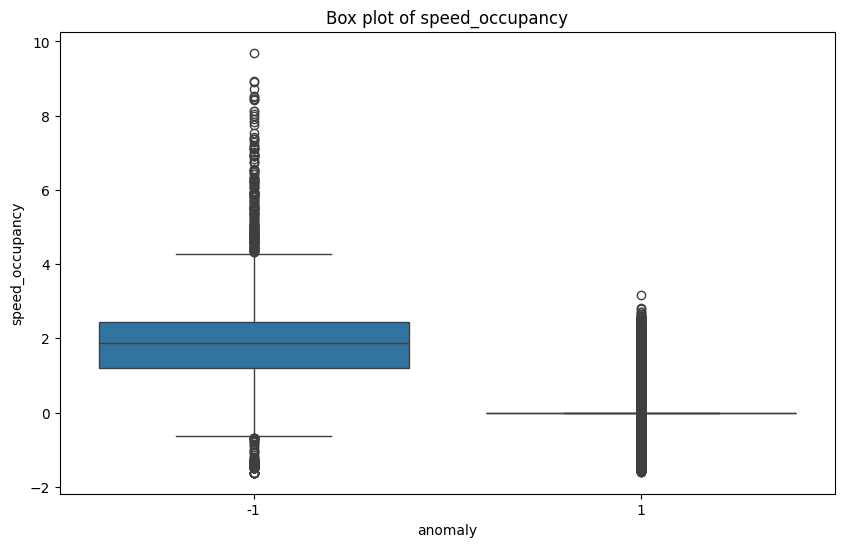

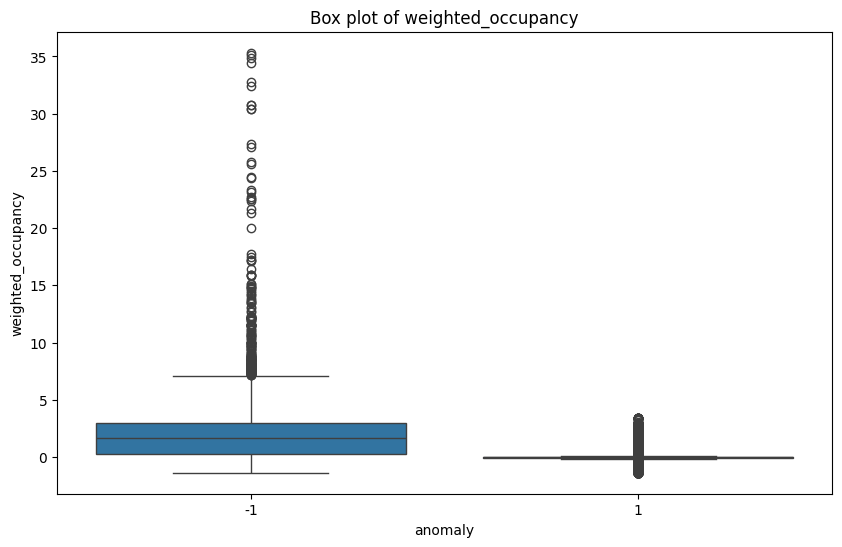

In [4]:
features_to_plot = ['speed_inv', 'flow_speed_ratio', 'occupancy_flow', 'speed_occupancy', 'weighted_occupancy']
for feature in features_to_plot:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='anomaly', y=feature, data=combined_results)
    plt.title(f'Box plot of {feature}')
    plt.show()

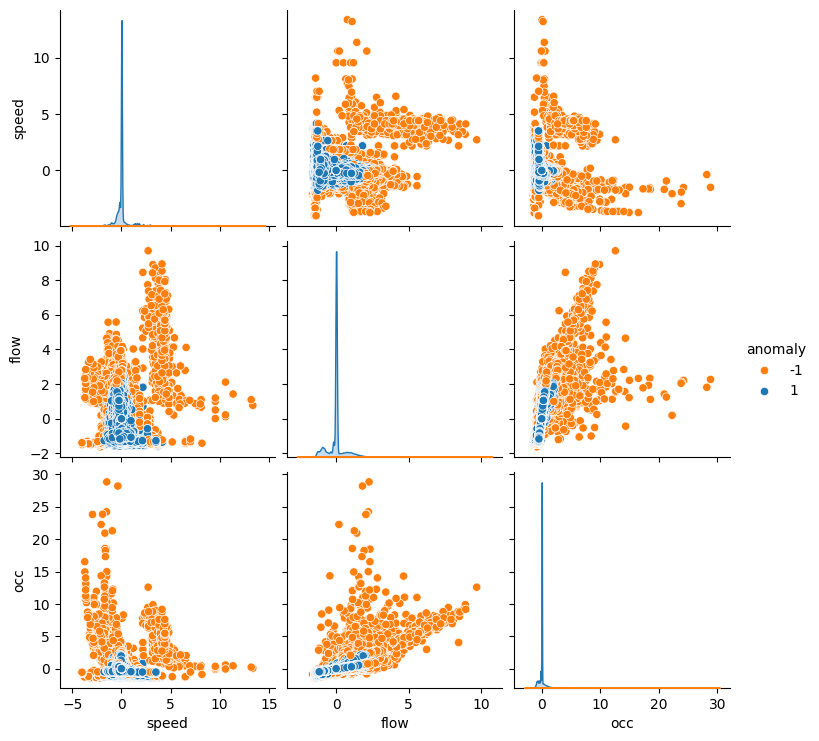

In [5]:
# Isolation Forest without Feature Engineering

det_ids = df['detid'].unique()
combined_results = pd.DataFrame()
sensor_models = {}

for det_id in det_ids:
    sensor_data = df[df['detid'] == det_id].copy()
    
    # Scale features
    features_to_scale = ['speed', 'flow', 'occ']
    scaler = StandardScaler()
    sensor_data[features_to_scale] = scaler.fit_transform(sensor_data[features_to_scale])
    
    # Train model
    clf = IsolationForest(contamination=0.05, random_state=42)
    clf.fit(sensor_data[features_to_scale])

    sensor_models[det_id] = clf

    # Anomaly score and label
    sensor_data['anomaly_score'] = clf.decision_function(sensor_data[features_to_scale])
    sensor_data['anomaly'] = clf.predict(sensor_data[features_to_scale])

    # Combine results into one dataframe
    combined_results = pd.concat([combined_results, sensor_data], ignore_index=True)

# Display combined results
palette = ['#ff7f0e', '#1f77b4']
sns.pairplot(combined_results, vars=['speed', 'flow', 'occ'], hue='anomaly', palette=palette)

plt.show()

In [12]:
##Calculate average speeds and determine threshhold for k-Fold Cross Validation as the second comparative methodology
#from sklearn.metrics import confusion_matrix, classification_report
#
## Calculate avg speed
#average_speeds = df.groupby('detid')['speed'].mean()
#
## If speed less than 50% of average, label as anomaly
#thresholds = average_speeds * 0.5
#
## Create a new column to represent anomaly label
#df['anomaly_label'] = df.apply(lambda row: 1 if row['speed'] < thresholds[row['detid']] else 0, axis=1)
#
## Zero Speeds
#df.loc[df['speed'] == 0, 'speed'] = np.finfo(float).eps
#
## Feature Engineering
#df['speed_inv'] = 1 / df['speed']
#df['flow_speed_ratio'] = df['flow'] / df['speed']
#df['occupancy_flow'] = df['occ'] * df['flow']
#df['speed_occupancy'] = df['speed'] * df['occ']
#df['weighted_occupancy'] = df['occ'] * df['speed_inv']
#
## Features
#features = ['speed_inv', 'flow_speed_ratio', 'occupancy_flow', 'speed_occupancy', 'weighted_occupancy']
#X = df[features]
#
##Standardize
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)
#
##Setup k-Fold Cross Validation
#kf = KFold(n_splits=5, shuffle=True, random_state=42)
#
#performance_metrics = []
#
## Run k-Fold Cross-Validation
#for train_index, test_index in kf.split(X_scaled):
#    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
#    y_test = df.iloc[test_index]['anomaly_label']
#    
#    # Isolation Forest
#    clf = IsolationForest(contamination=0.05, random_state=42)
#    clf.fit(X_train)
#
#    # Predict
#    y_pred = clf.predict(X_test)
#    y_pred = np.where(y_pred == 1, 0, 1)
#    
#    # Evaluate
#    cm = confusion_matrix(y_test, y_pred)
#    cr = classification_report(y_test, y_pred, target_names=['Normal', 'Anomaly'])
#    performance_metrics.append((cm, cr))
#
## Output
#for i, (cm, cr) in enumerate(performance_metrics, 1):
#    print(f"Results for Fold {i}:")
#    print("Confusion Matrix:\n", cm)
#    print("Classification Report:\n", cr)

Results for Fold 1:
Confusion Matrix:
 [[34610  1326]
 [ 3570   494]]
Classification Report:
               precision    recall  f1-score   support

      Normal       0.91      0.96      0.93     35936
     Anomaly       0.27      0.12      0.17      4064

    accuracy                           0.88     40000
   macro avg       0.59      0.54      0.55     40000
weighted avg       0.84      0.88      0.86     40000

Results for Fold 2:
Confusion Matrix:
 [[34661  1293]
 [ 3525   521]]
Classification Report:
               precision    recall  f1-score   support

      Normal       0.91      0.96      0.94     35954
     Anomaly       0.29      0.13      0.18      4046

    accuracy                           0.88     40000
   macro avg       0.60      0.55      0.56     40000
weighted avg       0.84      0.88      0.86     40000

Results for Fold 3:
Confusion Matrix:
 [[34578  1382]
 [ 3525   515]]
Classification Report:
               precision    recall  f1-score   support

      Nor